## Spectral GCN 

Implementation based on the paper: <i>Semi-supervised Classification With Graph Convolutional Networks</i>.

In [1]:
import numpy as np
import tensorflow as tf
import spektral
import random
import scipy
from sklearn.utils import shuffle
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.layers import Input,Dense,Reshape,Activation,Flatten,Concatenate,Embedding
from tensorflow.keras.models import Model
from sklearn.metrics import balanced_accuracy_score

import warnings
warnings.filterwarnings('ignore')

### CORA Dataset

2708 scientific publications, each represented by 1433 binary-word-count features, with 7 unique classes of papers.

In [2]:
graph = spektral.datasets.citation.Citation('cora',random_split=False,normalize_x=False)
graph = graph[0]
graph

Graph(n_nodes=2708, n_node_features=1433, n_edge_features=None, n_labels=7)

In [3]:
# a: adjacency matrix (edge weights are 1 or 0, undirected graph), x: node features, y: labels
a,x,y = graph['a'],graph['x'],graph['y']
y = np.argmax(y,axis=-1).astype("int32")
a = np.asarray(a.todense())
d = np.diag(np.sum(a,axis=-1)) # degree matrix
print(a.shape,x.shape,y.shape,d.shape)
print(a.dtype,x.dtype,y.dtype,d.dtype)

(2708, 2708) (2708, 1433) (2708,) (2708, 2708)
float32 float32 int32 float32


In [4]:
d_ = scipy.linalg.fractional_matrix_power(d,-0.5)
a_ = a+np.diag(np.ones(len(a)))
a_hat = (d_.dot(a_).dot(d_)).astype("float32")
print(a_hat.shape)

(2708, 2708)


In [5]:
a_hat = tf.convert_to_tensor(a_hat)
x = tf.convert_to_tensor(x)
print(a_hat.shape,x.shape)

(2708, 2708) (2708, 1433)


### Spectral GCN & CORA Classification

In [6]:
# creating the train,test sets - getting indices for each
indices = np.array([i for i in range(len(y))])
indices_per_class = [indices[y==i] for i in range(7)]
test_indices = np.hstack([class_i[0:50] for class_i in indices_per_class]) # equal number of all classes
train_indices = np.hstack([class_i[50:] for class_i in indices_per_class])
test_y = y[test_indices]
train_y = y[train_indices]

train_mask = np.zeros(y.shape).astype("float32") # getting loss mask so that only train data used to update params
train_mask[train_indices]=1

print(train_indices.shape,test_indices.shape,train_mask.shape)
print(train_y.shape,test_y.shape)

(2358,) (350,) (2708,)
(2358,) (350,)


In [7]:
dense_1 = Dense(128,activation="relu")
dense_2 = Dense(128,activation="relu")
dense_3 = Dense(128,activation="relu")
dense_4 = Dense(7,activation=None) # logits
scc_loss = SparseCategoricalCrossentropy(from_logits=True)

In [8]:
optimizer=Adam(lr=0.001)
epochs=50

for epoch_i in range(epochs): # full-batch gradient descent
    losses = []
    layer_in = x
    with tf.GradientTape() as tape:
        layer_in = dense_1(tf.linalg.matmul(a_hat,layer_in))
        layer_in = dense_2(tf.linalg.matmul(a_hat,layer_in))
        layer_in = dense_3(tf.linalg.matmul(a_hat,layer_in))
        logits = dense_4(tf.linalg.matmul(a_hat,layer_in))
        loss = scc_loss(y,logits,sample_weight=train_mask) # only use training data
    
    gradients = tape.gradient(loss,dense_1.trainable_variables+dense_2.trainable_variables+dense_3.trainable_variables+dense_4.trainable_variables)
    optimizer.apply_gradients(zip(gradients,dense_1.trainable_variables+dense_2.trainable_variables+dense_3.trainable_variables+dense_4.trainable_variables))
    losses.append(float(loss))
    
    node_predictions = np.argmax(logits.numpy(),axis=-1)
    test_pred,train_pred = node_predictions[test_indices],node_predictions[train_indices]
    train_acc = balanced_accuracy_score(train_y,train_pred)
    test_acc = balanced_accuracy_score(test_y,test_pred)
    print("epoch {}; loss:{}, train_acc:{}, test_acc:{}".format(epoch_i+1,round(sum(losses)/len(losses),4),round(train_acc,4),round(test_acc,4)))

epoch 1; loss:1.7039, train_acc:0.1206, test_acc:0.1343
epoch 2; loss:1.6162, train_acc:0.1915, test_acc:0.1971
epoch 3; loss:1.5535, train_acc:0.174, test_acc:0.1657
epoch 4; loss:1.5023, train_acc:0.1672, test_acc:0.1629
epoch 5; loss:1.4552, train_acc:0.1736, test_acc:0.1714
epoch 6; loss:1.4076, train_acc:0.1854, test_acc:0.1743
epoch 7; loss:1.3575, train_acc:0.2081, test_acc:0.1971
epoch 8; loss:1.3045, train_acc:0.2417, test_acc:0.2257
epoch 9; loss:1.2488, train_acc:0.2637, test_acc:0.2457
epoch 10; loss:1.19, train_acc:0.3131, test_acc:0.3
epoch 11; loss:1.1286, train_acc:0.3783, test_acc:0.3571
epoch 12; loss:1.0652, train_acc:0.4255, test_acc:0.3914
epoch 13; loss:1.0008, train_acc:0.4649, test_acc:0.4486
epoch 14; loss:0.9363, train_acc:0.5284, test_acc:0.5057
epoch 15; loss:0.8718, train_acc:0.5635, test_acc:0.56
epoch 16; loss:0.808, train_acc:0.5978, test_acc:0.5914
epoch 17; loss:0.7458, train_acc:0.6086, test_acc:0.6029
epoch 18; loss:0.6861, train_acc:0.6252, test_acc

### Visualization

In [9]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [10]:
tsne_emb = TSNE(n_components=2).fit_transform(layer_in.numpy())
print(tsne_emb.shape)

(2708, 2)


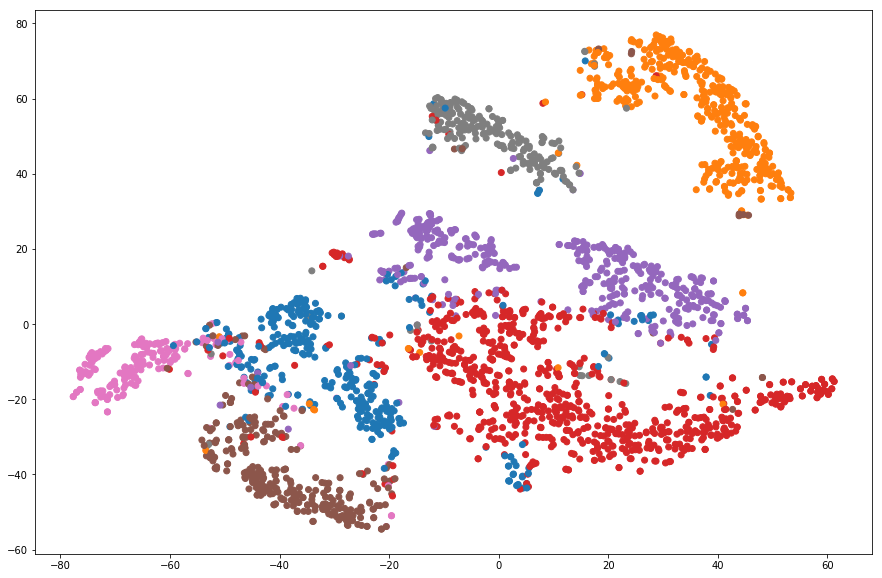

In [11]:
color_mapper = {0:'#1f77b4',1:'#7f7f7f',2:'#ff7f0e',3:'#d62728',4:'#9467bd',5:'#8c564b',6:'#e377c2'}
colors = [color_mapper[y[i]] for i in range(len(y))]

plt.figure(figsize=(15,10))
plt.scatter(tsne_emb[:,0],tsne_emb[:,1],c=colors)
plt.show()